In [1]:
# !pip install mujoco > /dev/null

In [4]:
# ! pip install stable-baselines3[extra]

UsageError: Line magic function `%` not found.


In [1]:
# Set up GPU rendering.
# import os
# import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

In [2]:
import mujoco

# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media

In [3]:
model_xml = '''
<mujoco>
  <!-- This file specifies things in degrees. The code/simulator uses radians -->
  <compiler autolimits="true" angle="degree"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".05"/>
    <mesh name="chasis" scale=".01 .006 .0015"
      vertex=" 9   2   0
              -10  10  10
               9  -2   0
               10  3  -10
               10 -3  -10
              -8   10 -10
              -10 -10  10
              -8  -10 -10
              -5   0   20"/>
  </asset>

  <asset>
    <mesh file="Basis_m.stl"/>
    <!-- <mesh file="ODrive_m.stl"/> -->
    <!-- <mesh file="Nucleo_m.stl"/> -->
    <!-- <mesh file="Battery_m.stl"/> -->
  </asset>

  <visual>
    <headlight ambient="0.5 0.5 0.5" />

    <!-- <headlight diffuse=".1 .1 .1" /> -->
    <!-- <headlight specular=".1 .1 .1"/> -->
  </visual>

  <option timestep="0.001" integrator="RK4"/>

  <default>
    <geom rgba="1. 1. 1. 1."/>
    <!-- <joint damping="0.01"/> -->
    <default class="wheel">
      <geom type="cylinder" size=".03 .01"/>
    </default>
    <default class="decor">
      <site type="box"/>
    </default>
  </default>

  <worldbody>
    <geom type="plane" size="50 50 .01" material="grid"/>
    <body name="pendulum" pos="0 0 0" euler="0 0 0">

        <freejoint/>

        <!-- <geom name="bodygeom" type="box" pos="0 0 0.25" size=".05 .05 .05" mass="1.5" rgba="0.9 0.9 0.9 0.1"/> -->

        <site name="wheelbase" pos="0 0 0"/>
        <camera name="tracking_cam" pos="0 -1.0 0.6" xyaxes="1 0 0 0 1 2" mode="track"/>
        <geom name="CoMViz" type="box" pos="-0.0055 0 0.24" size=".001 .001 .001" mass="0.0001" rgba="0.0 1.0 0.0 1.0"/>

        <site name="accel_site" pos="0 0 0.37"/>
        <geom name="accel" type="box" pos="0 0 0.37" size=".01 .01 .01" mass="0" rgba="0.0 1.0 0.0 1.0"/>

        <body name="leftwheel" pos=".0 .06 0" zaxis="0 1 0">
            <joint name="left"/>
            <geom class="wheel" mass="0.150"/>
            <site class="decor" size=".006 .025 .012"/>
            <site class="decor" size=".025 .006 .012"/>
        </body>

        <body name="rightwheel" pos=".0 -.06 0" zaxis="0 1 0">
            <joint name="right"/>
            <site name="torque_sensor_mnt" pos="0 0 0"/>
            <geom class="wheel" mass="0.150"/>
            <site class="decor" size=".006 .025 .012"/>
            <site class="decor" size=".025 .006 .012"/>
        </body>

        <body name="beam" pos="0 0 0.25">
            <!-- <geom name="rod" type="cylinder" pos="0 0 -0.125" size=".01 .125" mass="0.3" rgba ="0.9 0.9 0.9 0.1"/> -->
            <!-- <geom name="body" type="sphere" pos="0 0 0.02" size="0.05 0.05 0.05" mass="0.8" rgba ="0.9 0.9 0.9 0.1"/> -->
            <geom type="mesh" mesh="Basis_m" pos="0 0 0.033" size="0.01 0.01 0.01" euler="90 90 0" mass="0.810"/>
            <!-- <geom type="mesh" mesh="Nucleo_m" pos="-0.05 0 0.11" size="0.01 0.01 0.01" euler="90 180 0" mass="0.50"/> -->
            <!-- <geom type="mesh" mesh="ODrive_m" pos="0.04 -0.07 0.01" size="0.01 0.01 0.01" euler="0 0 90" mass="0.120"/> -->
            <!-- <geom type="mesh" mesh="Battery_m" pos="0 0 0.033" size="0.01 0.01 0.01" euler="90 90 0" mass="0.810"/> -->
        </body>

    </body>
  </worldbody>

  <actuator>
    <motor name="forward_left" joint="left" gear="1"/>
    <motor name="forward_right" joint="right" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="accel_site" noise="0.0"/>
    <gyro name="gyro" site="accel_site" noise="0.0"/>
    <framequat name="angle_sensor" objtype="site" objname="wheelbase"/>
    <framepos name="base_position" objtype="site" objname="wheelbase"/>
    <framelinvel name="base_velocity" objtype="site" objname="wheelbase"/>
    <frameangvel name="base_ang_velocity" objtype="site" objname="wheelbase"/>
    <torque name="wheel_torque" site="torque_sensor_mnt"/>
    <jointvel name="wheel_vel" joint="right"/>
    <jointpos name="wheel_pos" joint="right"/>
  </sensor>
</mujoco>
'''

In [4]:
m = mujoco.MjModel.from_xml_string(model_xml)
d = mujoco.MjData(m)

In [5]:
mujoco.mj_step(m, d)

""

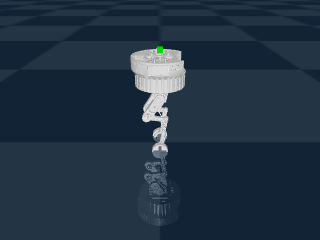

In [6]:
with mujoco.Renderer(m) as renderer:
    mujoco.mj_forward(m, d)
    renderer.update_scene(d, "tracking_cam")

    media.show_image(renderer.render())

In [7]:
# duration = 3.8  # (seconds)
# framerate = 60  # (Hz)

# # Simulate and display video.
# frames = []
# mujoco.mj_resetData(m, d)  # Reset state and time.
# with mujoco.Renderer(m) as renderer:
#     while d.time < duration:
#         mujoco.mj_step(m, d)
#         if len(frames) < d.time * framerate:
#             renderer.update_scene(d, "tracking_cam")
#             pixels = renderer.render()
#             frames.append(pixels)

# media.show_video(frames, fps=framerate)

In [8]:
import gym
import numpy as np
from types import SimpleNamespace as sn # For convenient indexing

In [9]:
def quaternion_to_euler(q):
    # Extract components
    w, x, y, z = q

    # Conversion
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = np.arctan2(t3, t4)

    return roll_x, pitch_y, yaw_z

In [13]:
class BasisEnv(gym.Env):
    state_vars = sn(**{"x": 0, "theta": 1, "x_dot": 2, "theta_dot": 3, "len": 4})

    action_to_torque = 1.0
    theta_threshold = np.pi / 2

    model = mujoco.MjModel.from_xml_string(model_xml)
    data  = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 24}
    frames = []
    max_frames = 100

    def __init__(self, render_mode = None, episode_step_count=100):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

        # Angle limit set to 2 * theta_threshold so failing observation is within bounds
        obs_max_limit = np.zeros(self.state_vars.len, dtype=np.float32)
        obs_max_limit[self.state_vars.x]         = np.finfo(np.float32).max
        obs_max_limit[self.state_vars.theta]     = self.theta_threshold * 2
        obs_max_limit[self.state_vars.x_dot]     = np.finfo(np.float32).max
        obs_max_limit[self.state_vars.theta_dot] = np.finfo(np.float32).max

        self.observation_space = gym.spaces.Box(low=-obs_max_limit, high=obs_max_limit, dtype=np.float32)

        self.state = np.zeros(self.state_vars.len)

        self.episode_step_count = episode_step_count
        self.remaining_steps = episode_step_count

        self.render_mode = render_mode

    def step(self, action):

        self.remaining_steps -= 1

        # Apply action and update sim and state
        self.apply_torque(action)
        self.step_physics()
        self.update_state()

        # Check if termination condition(s) are met
        terminated = bool((self.remaining_steps <= 0) or (self.state_out_of_bounds()))

        # Compute reward
        reward = self.compute_reward()

        # Compute observation
        observation = self.observe() # TODO: Add noise

        # Render
        if self.render_mode == "human":
            frame = self.render()
            # media.show_image(frame)
            if len(self.frames) < self.max_frames:
                self.frames.append(frame)

        return observation, reward, terminated, False, {}


    def render(self):
        renderer.update_scene(d, "tracking_cam")
        pixels = renderer.render()

        print("In renderer")
        return pixels

    def reset(self, seed=None):
        #### HUGE TODO!!! VERY IMPORTANT TO DO ASAP
        #### NEED TO RESET THE MUJOCO MODEL!
        super().reset(seed=seed)
        self.state[self.state_vars.x] = 0
        self.state[self.state_vars.theta] = 0
        self.state[self.state_vars.x_dot] = 0
        self.state[self.state_vars.theta_dot] = 0

        self.remaining_steps = self.episode_step_count

        return self.observe(), {}


    def apply_torque(self, action):
        self.data.ctrl = action * self.action_to_torque

    def step_physics(self):
        mujoco.mj_step(self.model, self.data)

    def update_state(self):
        x = self.data.sensor('wheel_pos').data[0]
        theta = quaternion_to_euler(self.data.sensor('angle_sensor').data)[1]
        x_dot = self.data.sensor('wheel_vel').data[0]
        theta_dot = d.sensor('base_ang_velocity').data[1]

        self.state[self.state_vars.x] = x
        self.state[self.state_vars.theta] = theta
        self.state[self.state_vars.x_dot] = x_dot
        self.state[self.state_vars.theta_dot] = theta_dot

    def state_out_of_bounds(self):
        return abs(self.state[self.state_vars.theta]) > self.theta_threshold

    def compute_reward(self):
        x_penalty_weight = 0.1
        x_setpoint = 0.0
        x_penalty = abs(x_setpoint - self.state[self.state_vars.x]) * x_penalty_weight

        alive_reward = 1.0

        return alive_reward - x_penalty

    def observe(self):
        # TODO: Add noise later
        return self.state


In [11]:
# env = gym.make('CartPole-v1', new_step_api=True)
env = BasisEnv(render_mode="rgb_array")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Box(-1.0, 1.0, (2,), float32)
Observation space: Box([-3.4028235e+38 -3.1415927e+00 -3.4028235e+38 -3.4028235e+38], [3.4028235e+38 3.1415927e+00 3.4028235e+38 3.4028235e+38], (4,), float32)


In [12]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1, device="cpu")
model.learn(total_timesteps=100, log_interval=4)
model.save("./models/sac_basis")

# del model # remove to demonstrate saving and loading


ModuleNotFoundError: No module named 'gymnasium.wrappers.monitoring'

In [ ]:
# Load the model
model = SAC.load("./models/sac_basis")

obs, info = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()